In [1]:
import tensorflow as tf
import numpy as np
import random
import os

## Setup seed for reproduce result

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Data preparation

In [3]:
#Train: https://drive.google.com/a/idrnd.net/file/d/1xmALNsYW-zm-Id9T6Ku2H4_cBWoqn23s
#Test: https://drive.google.com/a/idrnd.net/file/d/1teaLCo-F-5RCQM8Puxqbk13bI0evqIzg

train_dir = "./dataset/IDRND_FASDB_train"
log_dir = "./logs" #for tensorboard
checkpoint_dir = './checkpoints/vgg_antispoofing' #for saving weights in the process of fit
model_dir = "./model_vgg_antispoofing" #for save model

In [4]:
if not os.path.isdir(train_dir):
    print("You need to download dasates")

In [5]:
img_width = 384
img_height = 384
img_channels = 3
batch_size = 32

In [6]:
import glob

real_files = glob.glob(train_dir + "/real/*.png")
spoof_files = glob.glob(train_dir + "/spoof/*.png")

for file in (real_files + spoof_files):
    filename = file.split('/')[-1]
    if filename.startswith("."):
        print("Looks like a problem - you need remove hidden files:", file)
        break

In [7]:
X = real_files + spoof_files
y = np.concatenate((
    np.ones(len(real_files)), # real is 1
    np.zeros(len(spoof_files))), # spoof is 0
    axis=None
)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X, 
    y, 
    test_size = 0.2, 
    random_state = seed_value,
    stratify = y
)

In [9]:
import cv2

#Load image in two formats: hsv and yuv
def load_image(path):
    image = cv2.imread(path)
    h, w, c = image.shape
    dw, dh = w // 4, h // 4
    image = cv2.resize(image[dh:h-dh, dw:w-dw, :], (img_width, img_height))

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    hsv = hsv / 255.0
    yuv = yuv / 255.0
    hsv = hsv.astype(np.float32)
    yuv = yuv.astype(np.float32)
    return (hsv, yuv)

In [10]:
def get_label(path):
    pack_name = path.split('/')[-2]
    if pack_name == 'real':
        return 1
    else:
        return 0

## Make NN model

### Because we have deal with imbalance of classes - we need to make metric and loss function with weights

In [11]:
print("Count of real in dataset:", len(real_files))
print("Count of spoof in dataset", len(spoof_files))

Count of real in dataset: 1223
Count of spoof in dataset 7076


In [12]:
from tensorflow import ones_like, equal
from tensorflow.math import log
from tensorflow.math import multiply

class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [13]:
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(pos_weight=1):
    def _to_tensor(x, dtype):
        return tf.convert_to_tensor(x, dtype=dtype)
  
  
    def _calculate_weighted_binary_crossentropy(target, output, from_logits=False):
        if not from_logits:
            _epsilon = _to_tensor(K.epsilon(), output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
            output = log(output / (1 - output))
        target = tf.dtypes.cast(target, tf.float32)
        return tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=output, pos_weight=pos_weight)


    def _weighted_binary_crossentropy(y_true, y_pred):
        return K.mean(_calculate_weighted_binary_crossentropy(y_true, y_pred), axis=-1)
    
    return _weighted_binary_crossentropy

In [14]:
pos = (y_train == 1).astype(int).sum()
neg = (y_train == 0).astype(int).sum()
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [15]:
metrics = [
    BalancedSparseCategoricalAccuracy(),
    tf.keras.metrics.TruePositives(name='true_real'),
    tf.keras.metrics.FalsePositives(name='false_real'),
    tf.keras.metrics.TrueNegatives(name='true_spoof'),
    tf.keras.metrics.FalseNegatives(name='false_spoof'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

def make_model(metrics=metrics):
    input_hsv = tf.keras.layers.Input(name='hsv_input', shape=(img_height, img_width, img_channels))
    input_yuv = tf.keras.layers.Input(name='yuv_input', shape=(img_height, img_width, img_channels))
    
    vgg_hsv = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    vgg_hsv._name = "vgg_hsv"
        
    vgg_yuv = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    vgg_yuv._name = "vgg_yuv"
        
    vgg_hsv.trainable = False
    vgg_yuv.trainable = False
        
    vgg_hsv_output = vgg_hsv(input_hsv)
    vgg_yuv_output = vgg_yuv(input_yuv)
        
    feature = tf.keras.layers.concatenate([vgg_hsv_output, vgg_yuv_output])

    output = tf.keras.layers.Flatten()(feature)
    
    output = tf.keras.layers.Dense(units=128)(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Activation(activation=tf.nn.leaky_relu)(output)
    output = tf.keras.layers.Dropout(0.5)(output)
        
    output = tf.keras.layers.Dense(units=128)(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Activation(activation=tf.nn.leaky_relu)(output)
    output = tf.keras.layers.Dropout(0.5)(output)
    
    output = tf.keras.layers.Dense(1, name='output', activation="sigmoid")(output)
    #output = tf.keras.layers.Dense(1, name='output')(output)
    
    model = tf.keras.Model(inputs=[input_hsv, input_yuv], outputs=output)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_binary_crossentropy(weight_for_1),
        metrics=metrics
    )

    return model

In [16]:
model = make_model()

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hsv_input (InputLayer)          [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
yuv_input (InputLayer)          [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
vgg_hsv (Functional)            (None, None, None, 5 14714688    hsv_input[0][0]                  
__________________________________________________________________________________________________
vgg_yuv (Functional)            (None, None, None, 5 14714688    yuv_input[0][0]                  
_______________________________________________________________________________________

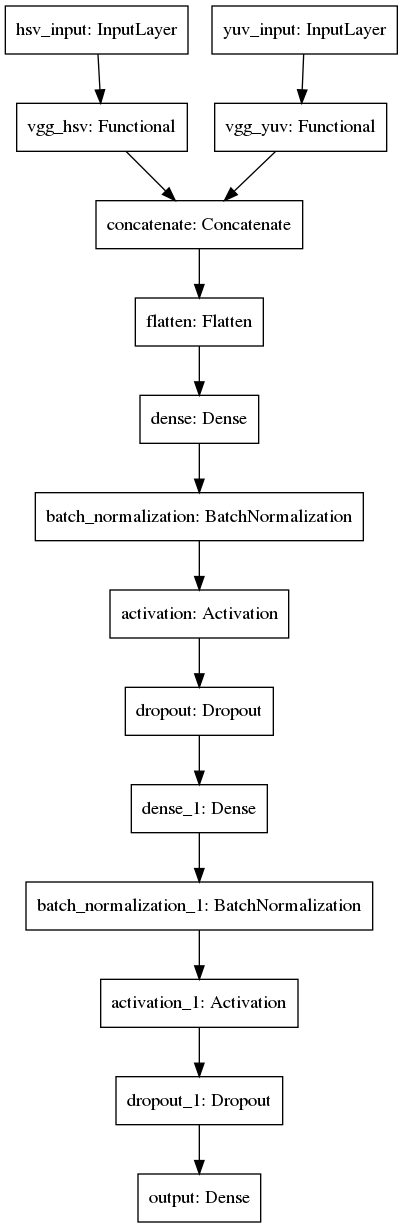

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
steps_per_epoch = int(len(X_train) / batch_size)
print("steps_per_epoch:", steps_per_epoch)

steps_per_epoch: 207


In [20]:
#Check signature of model

hsv = np.zeros((1, img_width, img_height, img_channels))
yuv = np.ones((1, img_width, img_height, img_channels))

model.evaluate([hsv, yuv])

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - balanced_sparse_categorical_accuracy: 0.0000e+00 - true_real: 0.0000e+00 - false_real: 0.0000e+00 - true_spoof: 0.0000e+00 - false_spoof: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
#Create callbacks

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#### We need to wrap of process of extract features in generator because it is heavy process

In [22]:
def train_generator():
    for path in X_train:
        hsv, yuv = load_image(path)
        label = get_label(path)
        yield (hsv, yuv), label

def validation_generator():
    for path in X_validation:
        hsv, yuv = load_image(path)
        label = get_label(path)
        yield (hsv, yuv), label
        
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    ((tf.float32, tf.float32), tf.int64)
).batch(batch_size).repeat().prefetch(1)

validation_dataset = tf.data.Dataset.from_generator(
    validation_generator,
    ((tf.float32, tf.float32), tf.int64)
).batch(batch_size).prefetch(1)

In [23]:
result = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch = steps_per_epoch,
    epochs=8,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/8
  1/207 [..............................] - ETA: 0s - loss: 1.7470 - balanced_sparse_categorical_accuracy: 0.0000e+00 - true_real: 1.0000 - false_real: 20.0000 - true_spoof: 6.0000 - false_spoof: 5.0000 - accuracy: 0.2188 - precision: 0.0476 - recall: 0.1667 - auc: 0.1955WARNING:tensorflow:From /home/euclid/.local/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
207/207 [==============================] - 160s 771ms/step - loss: 0.8006 - balanced_sparse_categorical_accuracy: 0.0314 - true_real: 808.0000 - false_real: 2060.0000 - true_spoof: 3587.0000 - false_spoof: 169.0000 - accuracy: 0.6635 - precision: 0.2817 - recall: 0.8270 - auc: 0.8276 - val_loss: 0.5450 - val_balanced_sparse_categorical_accuracy: 0.0096 - val_true_real: 236.0000 - val_false_real: 393.0000 - val_true_spoof: 1022.0

In [27]:
eval_res = model.evaluate(validation_dataset, return_dict=True, verbose=0)

In [28]:
eval_res

{'loss': 0.18052156269550323,
 'balanced_sparse_categorical_accuracy': 0.028846153989434242,
 'true_real': 218.0,
 'false_real': 10.0,
 'true_spoof': 1405.0,
 'false_spoof': 27.0,
 'accuracy': 0.9777644276618958,
 'precision': 0.9561403393745422,
 'recall': 0.8897958993911743,
 'auc': 0.9904247522354126}

In [29]:
model.save(model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_vgg_antispoofing/assets
